In [2]:
!pip install torch

    100% |████████████████████████████████| 582.5MB 86kB/s  eta 0:00:01   11% |███▋                            | 65.2MB 20.8MB/s eta 0:00:25    26% |████████▌                       | 153.9MB 40.6MB/s eta 0:00:11    31% |██████████                      | 183.5MB 16.5MB/s eta 0:00:25    37% |████████████                    | 219.0MB 12.4MB/s eta 0:00:30    51% |████████████████▍               | 298.0MB 38.3MB/s eta 0:00:08    56% |██████████████████              | 329.2MB 48.3MB/s eta 0:00:06    62% |████████████████████            | 364.7MB 48.9MB/s eta 0:00:05    78% |█████████████████████████▏      | 457.1MB 44.3MB/s eta 0:00:03    82% |██████████████████████████▎     | 478.1MB 59.1MB/s eta 0:00:02    86% |███████████████████████████▌    | 501.5MB 57.0MB/s eta 0:00:02    89% |████████████████████████████▋   | 521.4MB 42.9MB/s eta 0:00:02


In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [7]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    if (':' in s[:5]):
        s = s[:s.find(':')] + s[s.find(':') + 1:]
    s = unicodeToAscii(s.lower().strip())
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [11]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines1 = open('./real/data/question.txt').read().strip().split('\n')
    lines2 = open('./real/data/replies.txt').read().strip().split('\n')

    
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l] for l in list(zip(lines1, lines2))[-52*1000:]] # RAM over 20GB with full dataset

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [12]:
MAX_LENGTH = 7


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [13]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('rus', 'rus', True)
print(random.choice(pairs))
gc.collect()

Reading lines...
Read 52000 sentence pairs
Trimmed to 12529 sentence pairs
Counting words...
Counted words:
rus 17134
rus 14269
['ночи с:', 'даже он женственнее меня ._. http://t.co/nvy7qz2zmr']


0

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <https://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [15]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




Attention Decoder
^^^^^^^^^^^^^^^^^

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:





In [16]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [17]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [18]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [19]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [20]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [14]:
#!pip install matplotlib

In [21]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [22]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [23]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




1m 10s (- 117m 6s) (1000 1%) 5.4145
1m 31s (- 74m 31s) (2000 2%) 5.3589
1m 50s (- 59m 30s) (3000 3%) 5.3635
2m 7s (- 50m 54s) (4000 4%) 5.2630
2m 27s (- 46m 40s) (5000 5%) 5.1182
2m 46s (- 43m 25s) (6000 6%) 5.0733
3m 1s (- 40m 17s) (7000 7%) 5.0109
3m 22s (- 38m 49s) (8000 8%) 4.8508
3m 41s (- 37m 20s) (9000 9%) 4.8646
3m 57s (- 35m 35s) (10000 10%) 4.8801
4m 17s (- 34m 42s) (11000 11%) 4.8102
4m 37s (- 33m 55s) (12000 12%) 4.8310
4m 51s (- 32m 31s) (13000 13%) 4.7735
5m 11s (- 31m 56s) (14000 14%) 4.8409
5m 32s (- 31m 25s) (15000 15%) 4.6838
5m 47s (- 30m 23s) (16000 16%) 4.7457
6m 7s (- 29m 55s) (17000 17%) 4.7334
6m 28s (- 29m 29s) (18000 18%) 4.7138
6m 44s (- 28m 42s) (19000 19%) 4.6496
7m 2s (- 28m 8s) (20000 20%) 4.4992
7m 22s (- 27m 45s) (21000 21%) 4.6172
7m 41s (- 27m 15s) (22000 22%) 4.5407
7m 56s (- 26m 34s) (23000 23%) 4.4566
8m 16s (- 26m 13s) (24000 24%) 4.5208
8m 37s (- 25m 52s) (25000 25%) 4.4858
8m 51s (- 25m 13s) (26000 26%) 4.5441
9m 12s (- 24m 53s) (27000 27%) 4.47

<Figure size 432x288 with 0 Axes>

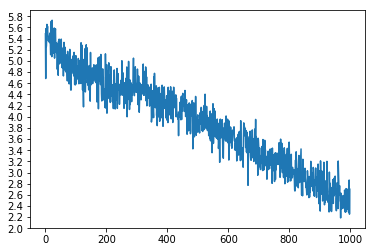

In [26]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 100000, print_every=1000)

In [75]:
input_sentence = ""
output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)
output_sentence = ' '.join(output_words)
print(output_sentence)

ихихи <EOS>


2m 7s (- 104m 25s) (1000 2%) 1.1430
2m 31s (- 60m 45s) (2000 4%) 1.1699
2m 49s (- 44m 15s) (3000 6%) 1.0880
3m 12s (- 36m 57s) (4000 8%) 1.1453
3m 35s (- 32m 21s) (5000 10%) 1.1061
3m 55s (- 28m 43s) (6000 12%) 1.0141
4m 19s (- 26m 31s) (7000 14%) 1.1316
4m 39s (- 24m 27s) (8000 16%) 1.0925
5m 1s (- 22m 51s) (9000 18%) 1.0412
5m 25s (- 21m 41s) (10000 20%) 1.0229
5m 43s (- 20m 16s) (11000 22%) 0.9978
6m 6s (- 19m 19s) (12000 24%) 1.0022
6m 29s (- 18m 29s) (13000 26%) 1.0644
6m 46s (- 17m 25s) (14000 28%) 1.0218
7m 10s (- 16m 45s) (15000 30%) 0.9049
7m 33s (- 16m 3s) (16000 32%) 0.9874
7m 50s (- 15m 14s) (17000 34%) 1.0107
8m 15s (- 14m 40s) (18000 36%) 0.9706
8m 36s (- 14m 1s) (19000 38%) 0.9366
8m 55s (- 13m 23s) (20000 40%) 0.9616
9m 20s (- 12m 53s) (21000 42%) 0.9579
9m 38s (- 12m 16s) (22000 44%) 0.9124
10m 0s (- 11m 45s) (23000 46%) 0.8202
10m 24s (- 11m 16s) (24000 48%) 0.9466
10m 43s (- 10m 43s) (25000 50%) 0.8474
11m 8s (- 10m 16s) (26000 52%) 0.8886
11m 31s (- 9m 49s) (27000 5

<Figure size 432x288 with 0 Axes>

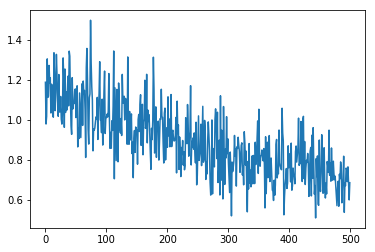

In [119]:
trainIters(encoder1, attn_decoder1, 50000, print_every=1000)

In [118]:
input_sentence = ""
output_words, attentions = evaluate(test_model, attn_decoder1, input_sentence)
output_sentence = ' '.join(output_words)
print(output_sentence)

ты ведь обещал. :с <EOS>


In [120]:
evaluateRandomly(encoder1, attn_decoder1)

> музыку слушаю
= сижуnты?
< сижуnты? <EOS>

> сигна для  http://t.co/izro00ve6i
= кому сигну #rt
< кому сигну #rt <EOS>

> нет, только в панораме.
= вроде 'пивная застава', да?
< вроде 'пивная <EOS>

> хочу татy,но я молчу
= через 20 мин поговорим?
< через 20 мин поговорим? <EOS>

> волк в овечьеи шкуре.
= поспешность нужна при ловле блох.
< поспешность нужна при ловле блох. <EOS>

> вот и отлично
= я не несу чепуху, это правда
< я не несу чепуху, это правда <EOS>

> лол , ты классныи)))
= хорошо с:
< хорошо с: <EOS>

> привет :)
= вот и хорошо
< да) <EOS>

> олонджоооснс олон кен
= ахахах
< ахахах <EOS>

> объяснила как god  http://t.co/w4zbftzcdi
= так ты приедешь?
< так ты приедешь? <EOS>



Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




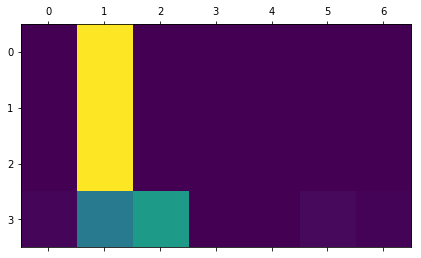

In [28]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "дела?")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




input = как дела .
output = да я в в <EOS>


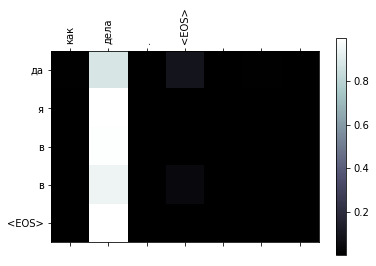

input = воу
output = ухожу <EOS>


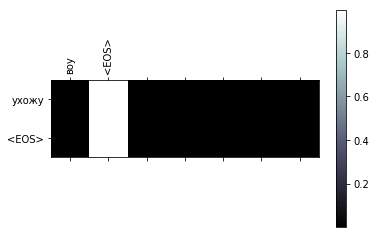

input = привет .
output = да <EOS>


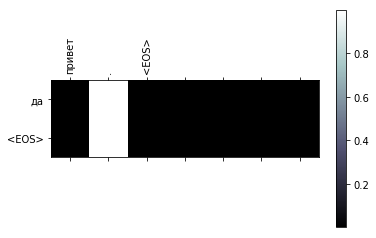

In [32]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)



evaluateAndShowAttention("как дела .")

evaluateAndShowAttention("воу")

evaluateAndShowAttention("привет .")

Exercises
=========

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there


